In [102]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample

In [221]:
#this is where all downladed data exists (after extracting the zip file)
PATH_TO_DATA = path.Path(r'C:\Users\User\Desktop\visualpilot')

#this will define the name of the location to save the processed csv files (note that it will also create a "batch" directory)
PATH_TO_PROCESSED = path.Path(r'C:\Users\User\Desktop\visualpilot\processed data3')

batch_name='batch3' #defines the name of the current subfolder to work on

In [222]:
PATH_TO_BATCH=PATH_TO_DATA / batch_name
AMAZON_WORKER_fILE_PATH= PATH_TO_DATA / path.Path(batch_name+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  30
number of participant files (of sufficient size) in the downloaded results batch: 32
number of unique participant names in the batch: 30

handling duplicate participants 2:
A1AC4JQFYLQFHV has 2 duplicate files  the largest file is not the latest, so need to resolve this conflict manualy
AS66AO98XNCUP has 2 duplicate files  the largest file is not the latest, so need to resolve this conflict manualy

after removing duplicate files, number of valid participant files = 32

going over the workers list as reported in amazon and finding a valid csv file for each
number of valid participants to go to further processing is: 30


In [203]:
batch_workers_df[['WorkerId','Approve','Reject','Answer.surveycode','csv_path']] #will add more columns with more information on disqualfication so we can decide if we pay or not

,WorkerId,Approve,Reject,Answer.surveycode,csv_path
0,A1J39RAV7TKEMF,x,NaN,tjs,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
1,A2EVO0JF0V6Q1,x,NaN,'tjs',A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv
2,AWT023NSAEQLX,NaN,no results file was found on pavlovia servers,8547965,NaN
3,A1XIXGOB9KUMPJ,x,NaN,tjs,A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv
4,A1STC10BXEP495,x,NaN,tjs,A1STC10BXEP495_2022-09-21_08h03.48.970.csv
5,AN7Z42U38BCQT,x,NaN,tjs,AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv
6,A8K19FZIUU2TE,x,NaN,tjs,A8K19FZIUU2TE_2022-09-21_09h30.55.475.csv
7,A19FW6H7BGKRVT,x,NaN,'tjs',A19FW6H7BGKRVT_2022-09-21_09h04.36.524.csv
8,ACR6012D868PP,x,NaN,tjs,ACR6012D868PP_2022-09-21_09h10.03.692.csv
9,A2U5OFMW8H30PC,x,NaN,tjs,A2U5OFMW8H30PC_2022-09-21_09h03.15.065.csv


In [204]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [205]:
def process_worker_results(PATH_TO_BATCH,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)


    #extract the demo test columns: 
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    sub_demo_test_information=cur_sub[demo_test_columns]
    empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

    demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    sub_encoding_information=cur_sub[encoding_related_columns]
    #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
    end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
    sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
    #remove all the rows that precede the real encoding phase: 
    empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
    sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    #extract real experiment TEST related information: 
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']
    sub_test_information=cur_sub[test_related_columns].iloc[end_of_section_ind+2:-1]


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['encoding_df']=sub_encoding_information
    subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [206]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_biographics_df.csv')

A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv
A1STC10BXEP495_2022-09-21_08h03.48.970.csv
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv
A8K19FZIUU2TE_2022-09-21_09h30.55.475.csv
A19FW6H7BGKRVT_2022-09-21_09h04.36.524.csv
ACR6012D868PP_2022-09-21_09h10.03.692.csv
A2U5OFMW8H30PC_2022-09-21_09h03.15.065.csv
A2TZVJFRJ5I61B_2022-09-21_09h06.25.253.csv
A1R5JNC2LO6X1S_2022-09-21_09h10.40.559.csv
A3L9EN8YL1HZWF_2022-09-21_09h42.50.613.csv
A1AT1U9SZ2T4NN_2022-09-21_10h01.27.159.csv
A3TF2L36Z80Y6N_2022-09-21_06h04.41.022.csv
A28JWKICT1X73Z_2022-09-21_09h03.23.661.csv
AJT7C07A187KA_2022-09-21_08h59.43.193.csv
AWC8CYV72QOLL_2022-09-21_09h03.54.498.csv
A2OT9ZJC4MQBS8_2022-09-21_09h03.35.681.csv
A1OAZCVZRC00F0_2022-09-21_09h07.42.002.csv
AHCIG4A3FXE6Q_2022-09-21_10h17.05.847.csv


In [207]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'Male':'male','MALE':'male','FEMALE':'female','Female':'female'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 36.35, range: [25 - 56], 0.55% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [208]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,1.9253,0.0,flower1.jpg,flower1_pair.jpg,left,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,left,0.0,2.0856,1.0,flower2_pair.jpg,flower2.jpg,right,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
2,6,2.0,left.jpg,left,1.3565,left,14.0,left,1.0,1.3420,2.0,flower3.jpg,flower3_pair.jpg,left,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,right,0.0,1.4469,3.0,flower4.jpg,flower4_pair.jpg,left,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,1.7806,4.0,flower5_pair.jpg,flower5.jpg,right,A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv


In [121]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,2512875899-126682.jpg,2460547536-274179.jpg,1.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
1,21,NaN,1.0,1.0,2964213381-294060.jpg,2458348012-349114.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
2,22,NaN,1.0,2.0,2452381505-199546.jpg,2898632385-217138.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
3,23,NaN,1.0,3.0,2874299429-139694.jpg,2883266367-365742.jpg,3.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
4,24,NaN,1.0,4.0,2460547467-349422.jpg,2868487415-213924.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv


In [34]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,1.0,right,right,1.0,2.4132,0.0,0.0,0.0,0.0,1.0,2864906345-212360.jpg,2575120738-55529.jpg,A3SSIUMI7ONK5W_2022-09-25_04h10.26.271.csv
1,3.0,left,left,1.0,0.8797,0.0,1.0,1.0,1.0,1.0,2883273443-68193.jpg,2898627427-366763.jpg,A3SSIUMI7ONK5W_2022-09-25_04h10.26.271.csv
2,3.0,left,right,0.0,0.6854,0.0,2.0,2.0,2.0,1.0,2883256307-365057.jpg,2864904453-63933.jpg,A3SSIUMI7ONK5W_2022-09-25_04h10.26.271.csv
3,1.0,left,left,1.0,0.5935,0.0,3.0,3.0,3.0,1.0,2874299429-139694.jpg,2986447306-296584.jpg,A3SSIUMI7ONK5W_2022-09-25_04h10.26.271.csv
4,3.0,left,right,0.0,0.4966,0.0,4.0,4.0,4.0,1.0,2238481198-19822.jpg,2238480803-19737.jpg,A3SSIUMI7ONK5W_2022-09-25_04h10.26.271.csv


In [209]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv,1.3565,1.0,0.666667,1.685600,1.766250,1.645275
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv,NaN,0.0,0.500000,2.643517,2.164533,3.122500
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv,NaN,0.0,0.833333,2.008850,1.637600,2.083100
A1STC10BXEP495_2022-09-21_08h03.48.970.csv,NaN,0.0,0.500000,4.616567,4.181900,5.051233
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv,NaN,0.0,0.500000,1.138567,0.223400,2.053733


In [210]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info.head(5)

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv,2.06115,0.4
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv,NaN,0.0
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv,1.28255,0.2
A1STC10BXEP495_2022-09-21_08h03.48.970.csv,NaN,0.0
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv,NaN,0.0


In [211]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))

for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()
    mean_rt=test_match_df['test_test_response.rt'].mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    correct_and_incorrect_rts=cur_sub_testing_performence.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info.head()

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv,0.566667,3.576398,3.560965,3.588200,3.604815,0.500000,3.938805,0.65,3.185575,0.55,4.0
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv,0.627119,1.872742,1.409909,2.147941,2.606832,0.578947,1.451760,0.60,1.596340,0.70,3.0
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv,0.666667,2.167772,2.737510,1.882903,2.852755,0.900000,1.853190,0.55,1.797370,0.55,6.0
A1STC10BXEP495_2022-09-21_08h03.48.970.csv,0.616667,2.402727,2.699583,2.218195,2.530875,0.550000,2.458410,0.60,2.218895,0.70,5.0
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv,0.516667,1.259675,0.092445,2.351600,0.092850,0.500000,0.087940,0.45,3.598235,0.60,24.0


In [212]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [213]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)
data_df_for_analysis


#define thresholds: 
demo_accuracy_treshold=0.5
demo_arrow_correctness=1
encoding_arrow_accuracy=0.6
longest_allowed_consequtive_strike=15
fast_threshold=0.3
fast_allowed_count=3
slow_threshold=10
slow_allowed_count=2


#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>demo_accuracy_treshold
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=demo_arrow_correctness
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>encoding_arrow_accuracy
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<longest_allowed_consequtive_strike

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=fast_threshold,fast_allowed_count=fast_allowed_count,slow_threshold=slow_threshold,slow_allowed_count=slow_allowed_count)
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)


print(f'summary for criterions:')
print(f'demo accuracy higher than {demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {fast_threshold}, allowed count: {fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {slow_threshold}, allowed count: {slow_allowed_count} qualified: {sum(too_slow_criterions)}')

only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')





summary for criterions:
demo accuracy higher than 0.5 - qualified: 7
demo attention check correctness equals 1 - qualified: 12
experiment encoding attention check accuracy 0.6 - qualified: 7
experiment longest consequtive strike of maximum of  15 responses - qualified: 16
test too fast (thresold: 0.3, allowed count: 3 qualified: 12
test too slow (thresold: 10, allowed count: 2 qualified: 18
OVERALL: number of qualified participants (adhere to all criterions): 4


In [214]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df],axis=1)
disqualification_df.head(5)


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast
A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv,True,True,False,True,True,True
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv,False,False,False,True,True,True
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv,True,False,False,True,True,True
A1STC10BXEP495_2022-09-21_08h03.48.970.csv,False,False,False,True,True,True
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv,False,False,False,False,True,False


In [215]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_for_upload.csv'))


In [216]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]

final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A8K19FZIUU2TE_2022-09-21_09h30.55.475.csv,0.8355,1.0,0.666667,2.605400,3.9334,1.941400,1.06106,1.0,0.516667,0.926632,0.892162,0.958877,1.013980,0.70,0.850230,0.20,0.915685,0.65,4.0
A2U5OFMW8H30PC_2022-09-21_09h03.15.065.csv,0.9488,1.0,1.000000,2.488933,NaN,2.488933,1.11614,1.0,0.883333,1.883287,1.889471,1.882470,1.947965,0.90,1.936245,0.90,1.765650,0.85,5.0
A3L9EN8YL1HZWF_2022-09-21_09h42.50.613.csv,1.1860,1.0,0.666667,3.771833,6.5400,2.387750,0.94480,1.0,0.800000,1.821067,2.010250,1.773771,1.873000,0.85,1.712650,0.75,1.877550,0.80,4.0
A28JWKICT1X73Z_2022-09-21_09h03.23.661.csv,1.2758,1.0,0.833333,1.744767,2.6112,1.571480,1.39376,1.0,0.866667,1.883880,1.431887,1.953417,2.694260,0.90,1.689595,0.85,1.267785,0.85,4.0


In [217]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,WorkerId
A1J39RAV7TKEMF_2022-09-21_09h07.39.041.csv,1.3565,1.0,0.666667,1.685600,1.766250,1.645275,2.06115,0.4,0.566667,3.576398,...,3.185575,0.55,4.0,True,True,False,True,True,True,A1J39RAV7TKEMF
A2EVO0JF0V6Q1_2022-09-21_09h23.24.584.csv,NaN,0.0,0.500000,2.643517,2.164533,3.122500,NaN,0.0,0.627119,1.872742,...,1.596340,0.70,3.0,False,False,False,True,True,True,A2EVO0JF0V6Q1
A1XIXGOB9KUMPJ_2022-09-21_09h19.13.047.csv,NaN,0.0,0.833333,2.008850,1.637600,2.083100,1.28255,0.2,0.666667,2.167772,...,1.797370,0.55,6.0,True,False,False,True,True,True,A1XIXGOB9KUMPJ
A1STC10BXEP495_2022-09-21_08h03.48.970.csv,NaN,0.0,0.500000,4.616567,4.181900,5.051233,NaN,0.0,0.616667,2.402727,...,2.218895,0.70,5.0,False,False,False,True,True,True,A1STC10BXEP495
AN7Z42U38BCQT_2022-09-21_09h14.53.949.csv,NaN,0.0,0.500000,1.138567,0.223400,2.053733,NaN,0.0,0.516667,1.259675,...,3.598235,0.60,24.0,False,False,False,False,True,False,AN7Z42U38BCQT


In [218]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_valid_subjects_only.csv')
total_data.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_all_subject.csv')

Text(0, 0.5, 'RT')

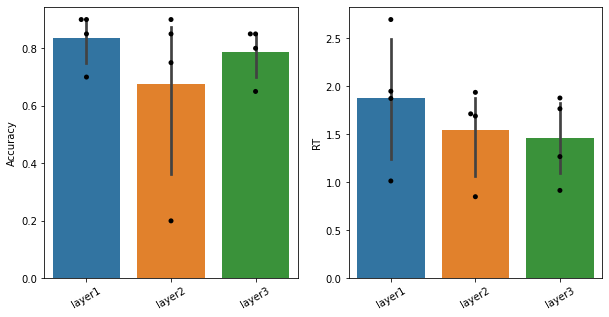

In [219]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

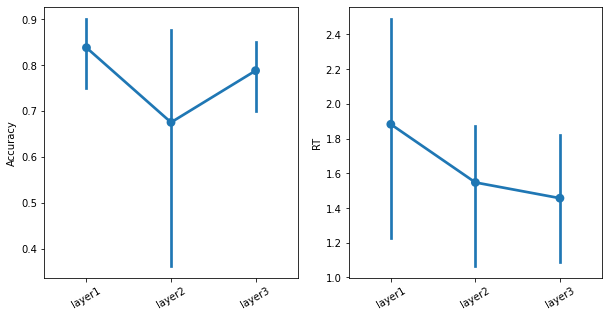

In [220]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')
